## import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import viridis
from matplotlib.cm import ScalarMappable
import matplotlib
from matplotlib.widgets import Slider,CheckButtons
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import savgol_filter,find_peaks
from tqdm import tqdm

import time
from collections import Counter
from pandas import Series

from impedance.visualization import plot_nyquist, plot_residuals, plot_bode
from impedance import preprocessing
from impedance.validation import linKK
from impedance.models.circuits import CustomCircuit

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor


## import EIS data, I, T as input and Q_rlt as output 

In [2]:
EISdata1 = pd.read_csv('EISdata1_SoC0_Cyc1to100.csv')
EISdata2 = pd.read_csv('EISdata2_SoC0_Cyc10to100.csv')

# Machine Learning Modeling

## Diagnose models

In [20]:
# split datasets into train, cv and test for diagnose
UD_train, UD_temp = train_test_split(EISdata1.loc[EISdata1['cycle_Nr'] > 4], test_size=0.2, random_state=42)
UD_cv, UD_test = train_test_split(UD_temp, test_size=0.5, random_state=42)

# define process_data function
def preprocess_data(data):
    X_pre = np.log10(data.loc[:, 'Re(Z)18.077':'-Im(Z)1390.0'])
    X = pd.concat([X_pre, np.sqrt(data['I(uA)'])], axis=1)
    y = data['Q_relative']
    return X, y

# prepare datasets
X_train, y_train = preprocess_data(UD_train)
X_cv, y_cv = preprocess_data(UD_cv)
X_test, y_test = preprocess_data(UD_test)

In [21]:
# Bayesian Regression
start_time = time.time()

poly_reg =Pipeline([
    ("poly", PolynomialFeatures(degree=3)),
    ("std_scaler",StandardScaler()),
    ("feature_selection", SelectFromModel(BayesianRidge())),
    ("bayesian_regression",BayesianRidge())    
])

poly_reg.fit(X_train,y_train)

# Model evaluation
train_score = poly_reg.score(X_train, y_train)
cv_score = np.mean(cross_val_score(poly_reg, X_cv, y_cv, cv=5))

# param=poly_reg.get_params(X_train,y_train)
predict_train=poly_reg.predict(X_train)
predict_cv=poly_reg.predict(X_cv)
predict_test, predict_std=poly_reg.predict(X_test,return_std=True)
y_pre_std = pd.DataFrame(data={'y_t':y_test,'y_pre':predict_test,'y_std':predict_std})

end_time = time.time()
run_time1 = end_time - start_time

print("running time：", run_time1, "seconds")

running time： 0.43723154067993164 seconds


In [22]:
X_poly = poly_reg.named_steps["poly"].get_feature_names_out()
X_scl = poly_reg.named_steps["std_scaler"].get_feature_names_out()
X_slt = poly_reg.named_steps["feature_selection"].get_feature_names_out()
coef = poly_reg.named_steps["bayesian_regression"].coef_

d1 = {'coef':coef,'X_scale':X_slt}
d2 = {'physic_names':X_poly,'X_scale':X_scl}
FS = pd.DataFrame(data=d1) # FS for feature selection
FA = pd.DataFrame(data=d2) # FA for features all
model_features = pd.merge(FS, FA, how = 'inner') 
model_features['abs_coef'] = np.absolute(model_features['coef']) 
model_features.sort_values('abs_coef',ascending=False)[0:20]

,coef,X_scale,physic_names,abs_coef
1237,-0.586264,x3275,I(uA)^3,0.586264
13,0.221305,x21,Re(Z)936.063,0.221305
701,0.199184,x1945,-Im(Z)39.8047 I(uA)^2,0.199184
526,0.197588,x1504,-Im(Z)26.8198 I(uA)^2,0.197588
805,0.191239,x2306,-Im(Z)59.0552 I(uA)^2,0.191239
912,0.160721,x2595,-Im(Z)87.684 I(uA)^2,0.160721
3,0.158101,x6,-Im(Z)39.8047,0.158101
372,0.153308,x975,-Im(Z)18.077 I(uA)^2,0.153308
187,-0.148849,x305,-Im(Z)286.568 I(uA),0.148849
15,0.144697,x23,Re(Z)1390.0,0.144697


<IPython.core.display.Javascript object>


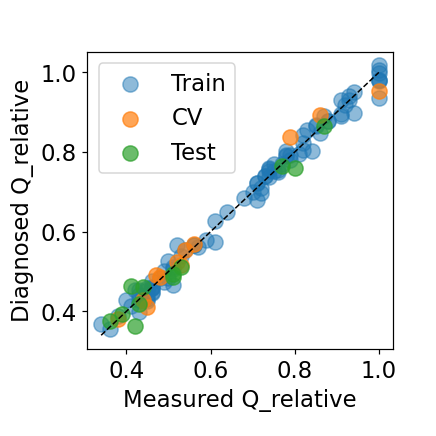

In [23]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train, s=100, marker='o',alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv, s=100, marker='o', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test, s=100, marker='o', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [26]:
# Neural Network

start_time = time.time()

poly_reg2 =Pipeline([
    ("poly", PolynomialFeatures(degree=1)),
    ("std_scaler",StandardScaler()),
    ("mlp_regress",MLPRegressor(solver = 'lbfgs',hidden_layer_sizes=[80,50,50,50],activation='relu',alpha=0.0001, max_iter=10000))
])

poly_reg2.fit(X_train,y_train)

train_score2 = poly_reg2.score(X_train, y_train)
cv_score2 = np.mean(cross_val_score(poly_reg2, X_cv, y_cv, cv=5))

predict_train2 = poly_reg2.predict(X_train)
predict_cv2 = poly_reg2.predict(X_cv)
predict_test2  = poly_reg2.predict(X_test)

end_time = time.time()
run_time2 = end_time - start_time

print("running time：", run_time2, "seconds")

running time： 0.6223585605621338 seconds


<IPython.core.display.Javascript object>


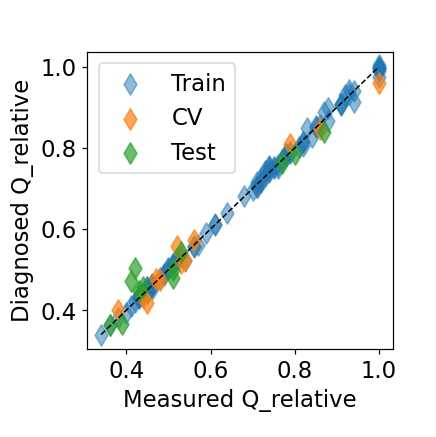

In [27]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train2, s=100, marker='d', alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv2, s=100, marker='d', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test2, s=100, marker='d', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [28]:
# Gaussian Process Regression

start_time = time.time()

poly_reg3 =Pipeline([
    ("poly", PolynomialFeatures(degree=3)),
    ("std_scaler",StandardScaler()),
#     ("feature_selection", SelectFromModel()),
    ("GaussianProcess_regression",GaussianProcessRegressor(kernel=1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)),
                                                           n_restarts_optimizer=9))    
])

poly_reg3.fit(X_train,y_train)

train_score3 = poly_reg3.score(X_train, y_train)
cv_score3 = np.mean(cross_val_score(poly_reg3, X_cv, y_cv, cv=5))

# param=poly_reg.get_params(X_train,y_train)
predict_train3=poly_reg3.predict(X_train)
predict_cv3 = poly_reg3.predict(X_cv)
predict_test3, predict_std3=poly_reg3.predict(X_test,return_std=True)
y_pre_std3 = pd.DataFrame(data={'y_t':y_test,'y_pre':predict_test3,'y_std':predict_std3})

end_time = time.time()
run_time3 = end_time - start_time

print("running time：", run_time3, "seconds")

running time： 2.140056848526001 seconds


<IPython.core.display.Javascript object>


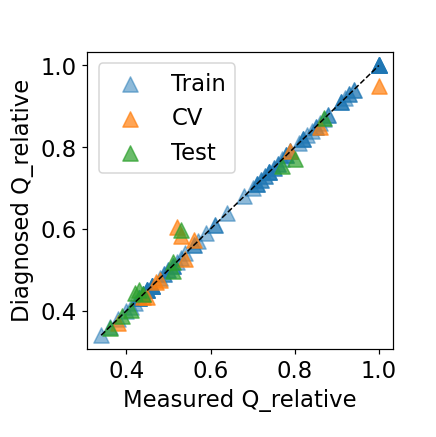

In [29]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train3, s=100, marker='^',alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv3, s=100, marker='^', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test3, s=100, marker='^', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [30]:
# Decision Tree
start_time = time.time()

poly_tree = Pipeline([
    ("poly", PolynomialFeatures(degree=1)),
    ("std_scaler", StandardScaler()),
    ("feature_selection", SelectFromModel(DecisionTreeRegressor())),
    ("decision_tree", DecisionTreeRegressor(ccp_alpha=0.0001))    
])

# Fit the pipeline on training data
poly_tree.fit(X_train, y_train)

train_score4 = poly_tree.score(X_train, y_train)
cv_score4 = np.mean(cross_val_score(poly_tree, X_cv, y_cv, cv=5))

# Predict on training and test data
predict_train4 = poly_tree.predict(X_train)
predict_cv4 = poly_tree.predict(X_cv)
predict_test4 = poly_tree.predict(X_test)

end_time = time.time()
run_time4 = end_time - start_time

print("running time：", run_time4, "seconds")

running time： 0.03322339057922363 seconds


<IPython.core.display.Javascript object>


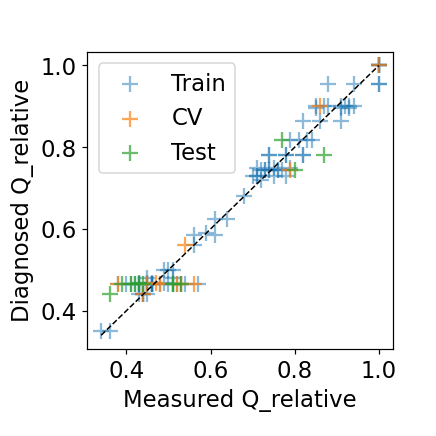

In [31]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(y_train, predict_train4, s=100, marker='+',alpha=0.5, label='Train')
ax.scatter(y_cv, predict_cv4, s=100, marker='+', alpha=0.7, label='CV')
ax.scatter(y_test, predict_test4, s=100, marker='+', alpha=0.7, label='Test')
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=1)
ax.set_xlabel('Measured Q_relative', fontdict={'size':15})
ax.set_ylabel('Diagnosed Q_relative', fontdict={'size':15})
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
# ax.fill_between(y_pre_std['y_pre'],y_pre_std['y_pre']-y_pre_std['y_std'],    
#                          y_pre_std['y_pre']+y_pre_std['y_std'], color="pink", alpha=0.5, label="predict std")
ax.legend(prop={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.gcf().subplots_adjust(left=0.2,bottom=0.2)


plt.show()

In [32]:
print("MSE_train:",metrics.mean_squared_error(y_train, predict_train) ,
      metrics.mean_squared_error(y_train, predict_train2),
      metrics.mean_squared_error(y_train, predict_train3),
      metrics.mean_squared_error(y_train, predict_train4))
print("MSE_CV:",mean_squared_error(y_cv, predict_cv),
      mean_squared_error(y_cv, predict_cv2),
      mean_squared_error(y_cv, predict_cv3),
      mean_squared_error(y_cv, predict_cv4))
print("MSE_test:",metrics.mean_squared_error(y_test, predict_test),
      metrics.mean_squared_error(y_test, predict_test2),
      metrics.mean_squared_error(y_test, predict_test3),
      metrics.mean_squared_error(y_test, predict_test4))


MSE_train: 0.00034239881425409335 6.171792023307002e-05 2.2010544532477625e-16 0.001034530279503106
MSE_CV: 0.0006910400945044024 0.000472552601882799 0.0011082321082317 0.002357412426776266
MSE_test: 0.0008134614144478292 0.0011948482840685286 0.0005917955673113336 0.0033982535548941826


In [33]:
print("MAE_train:", mean_absolute_error(y_train, predict_train) ,
      mean_absolute_error(y_train, predict_train2),
      mean_absolute_error(y_train, predict_train3),
      mean_absolute_error(y_train, predict_train4))
print("MAE_CV:",mean_absolute_error(y_cv, predict_cv),
      mean_absolute_error(y_cv, predict_cv2),
      mean_absolute_error(y_cv, predict_cv3),
      mean_absolute_error(y_cv, predict_cv4))
print("MAE_test:",mean_absolute_error(y_test, predict_test),
      mean_absolute_error(y_test, predict_test2),
      mean_absolute_error(y_test, predict_test3),
      mean_absolute_error(y_test, predict_test4))
print("R2:", r2_score(y_test, predict_test),
     r2_score(y_test, predict_test2),
     r2_score(y_test, predict_test3),
     r2_score(y_test, predict_test4))

MAE_train: 0.014352100662848321 0.005462932525016311 9.879599559341866e-09 0.023704710144927543
MAE_CV: 0.02070245563299959 0.018689435740653154 0.02180968788872888 0.03675099206349207
MAE_test: 0.022719984185458283 0.02617942146292405 0.01647765794494942 0.05539186507936509
R2: 0.971244490455497 0.9577626293927072 0.9790802823809819 0.8798732050508734


<IPython.core.display.Javascript object>


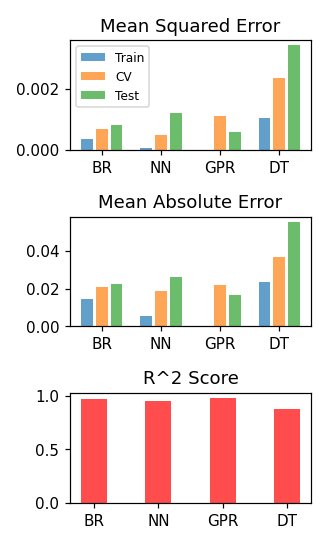

In [34]:
mse_train_values = [mean_squared_error(y_train, predict_train),
                    mean_squared_error(y_train, predict_train2),
                    mean_squared_error(y_train, predict_train3),
                    mean_squared_error(y_train, predict_train4)]

mse_cv_values = [mean_squared_error(y_cv, predict_cv),
                 mean_squared_error(y_cv, predict_cv2),
                 mean_squared_error(y_cv, predict_cv3),
                 mean_squared_error(y_cv, predict_cv4)]

mse_test_values = [mean_squared_error(y_test, predict_test),
                   mean_squared_error(y_test, predict_test2),
                   mean_squared_error(y_test, predict_test3),
                   mean_squared_error(y_test, predict_test4)]

mae_train_values = [mean_absolute_error(y_train, predict_train),
                    mean_absolute_error(y_train, predict_train2),
                    mean_absolute_error(y_train, predict_train3),
                    mean_absolute_error(y_train, predict_train4)]

mae_cv_values = [mean_absolute_error(y_cv, predict_cv),
                 mean_absolute_error(y_cv, predict_cv2),
                 mean_absolute_error(y_cv, predict_cv3),
                 mean_absolute_error(y_cv, predict_cv4)]

mae_test_values = [mean_absolute_error(y_test, predict_test),
                   mean_absolute_error(y_test, predict_test2),
                   mean_absolute_error(y_test, predict_test3),
                   mean_absolute_error(y_test, predict_test4)]

r2_values = [r2_score(y_test, predict_test),
             r2_score(y_test, predict_test2),
             r2_score(y_test, predict_test3),
             r2_score(y_test, predict_test4)]

# 
fig, axs = plt.subplots(3, 1, figsize=(3, 5))

# MSE plots
axs[0].bar(np.arange(len(mse_train_values)), mse_train_values, width=0.2, label='Train', align='center', alpha=0.7)
axs[0].bar(np.arange(len(mse_cv_values)) + 0.25, mse_cv_values, width=0.2, label='CV', align='center', alpha=0.7)
axs[0].bar(np.arange(len(mse_test_values)) + 0.5, mse_test_values, width=0.2, label='Test', align='center', alpha=0.7)
axs[0].set_title('Mean Squared Error')
axs[0].set_xticks(np.arange(len(mse_train_values)) + 0.25)
axs[0].set_xticklabels(['BR', 'NN', 'GPR', 'DT'])
axs[0].legend(fontsize=8)

# MAE plots
axs[1].bar(np.arange(len(mae_train_values)), mae_train_values, width=0.2, label='Train', align='center', alpha=0.7)
axs[1].bar(np.arange(len(mae_cv_values)) + 0.25, mae_cv_values, width=0.2, label='CV', align='center', alpha=0.7)
axs[1].bar(np.arange(len(mae_test_values)) + 0.5, mae_test_values, width=0.2, label='Test', align='center', alpha=0.7)
axs[1].set_title('Mean Absolute Error')
axs[1].set_xticks(np.arange(len(mae_train_values)) + 0.25)
axs[1].set_xticklabels(['BR', 'NN', 'GPR', 'DT'])
# axs[1].legend(fontsize=10)

# R^2 plots
axs[2].bar(np.arange(len(r2_values)), r2_values, width=0.4, align='center', alpha=0.7, color = 'red')
axs[2].set_title('R^2 Score')
axs[2].set_xticks(np.arange(len(r2_values)))
axs[2].set_xticklabels(['BR', 'NN', 'GPR', 'DT'])

# 
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


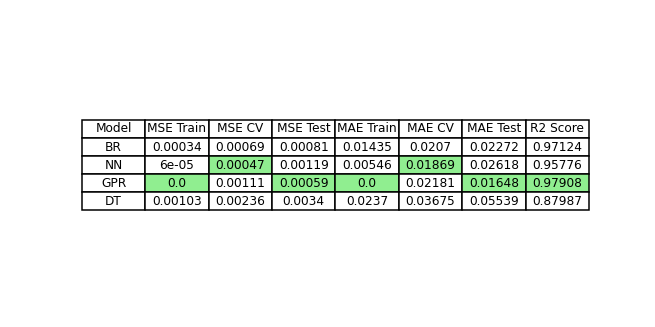

In [35]:
data = {
    'Model': ['BR', 'NN', 'GPR', 'DT'],
    'MSE Train': mse_train_values,
    'MSE CV': mse_cv_values,
    'MSE Test': mse_test_values,
    'MAE Train': mae_train_values,
    'MAE CV': mae_cv_values,
    'MAE Test': mae_test_values,
    'R2 Score': r2_values
}

df = pd.DataFrame(data)

# table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.round(5).values, colLabels=df.columns, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)

min_values = df.drop(columns='R2 Score').apply(min)
max_r2 = df['R2 Score'].max()

for col in df.columns[1:]:
    if col != 'R2 Score':
        min_val = min_values[col]
        min_index = df[df[col] == min_val].index[0]
        table[(min_index + 1, df.columns.get_loc(col))].set_facecolor('lightgreen')  # plus 1 for the title row
    else:
        max_index = df[df[col] == max_r2].index[0]
        table[(max_index + 1, df.columns.get_loc(col))].set_facecolor('lightgreen')  # plus 1 for the title row


plt.show()

<IPython.core.display.Javascript object>


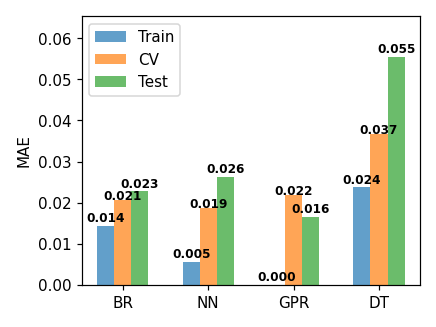

In [36]:
# Plotting the MAE values
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

# Bar plot positions
x = np.arange(len(mae_train_values))
width = 0.2

# MAE bar plots for Train, CV, and Test
ax.bar(x - width, mae_train_values, width=width, label='Train', align='center', alpha=0.7)
ax.bar(x, mae_cv_values, width=width, label='CV', align='center', alpha=0.7)
ax.bar(x + width, mae_test_values, width=width, label='Test', align='center', alpha=0.7)

# Set y-axis limit to the maximum MAE value + 0.1
max_value = max(mae_train_values + mae_cv_values + mae_test_values)
ax.set_ylim(0, max_value + 0.01)

# Adding titles and labels
# ax.set_title('Mean Absolute Error')
ax.set_xticks(x)
ax.set_xticklabels(['BR', 'NN', 'GPR', 'DT'])
ax.set_ylabel('MAE')
ax.legend(fontsize=10)

# Annotating each bar with the MAE values
for i, (train, cv, test) in enumerate(zip(mae_train_values, mae_cv_values, mae_test_values)):
    ax.text(i - width, train + 0.001, f"{train:.3f}", ha='center', fontsize=8, fontweight='bold')
    ax.text(i, cv + 0.0001, f"{cv:.3f}", ha='center',  fontsize=8, fontweight='bold')
    ax.text(i + width, test + 0.001, f"{test:.3f}", ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()